## Highlight potential target residues for engineering

From the project description:
> One of the main ways of developing therapeutic monoclonal antibodies is to immunize a non-human organism (typically mouse) and harvest it for its antibodies. Such non-human antibodies need then to be modified to make them more ‘human’ so they have less of a chance of eliciting an anti-mouse response.

A first way to aid the humanization effort is to compare the query sequence to the datasets of mouse and human sequences and find the sequence with the highest sequence similarity, specifying if it is human or mouse; the code is in `task2.py`.

Given the different functionality between FRs and CDRs, the humanization process should focus on framework regions (without modifying CDRs), in order to avoid an anti-mouse response while maintaining the desired affinity.

Thus, it would be useful to identify the positions in the query sequence that, on average, are not aligning well to human sequences, since these might be potential targets residues for engineering in the humanization process.

### Outline

1. Use ANARCI to compute the numbering of the query sequences together with the dataset of human sequences. The input .fasta files are concatenated usign bash commands.

2. Extract the multiple sequence alignment from the .csv file containing the numbering, as done in `task1c.ipynb`. This step will produce sequences of the same lenght, since ANARCI aligns sequences in a way that makes use of gaps to fit CDRs of different lenght, while keeping the framework regions aligned (see [IMGT](https://www.imgt.org/IMGTScientificChart/Numbering/IMGTIGVLsuperfamily.html)).

3. Split the alignments of all the sequences in order to store the aligned query sequences and the datasets sequences in two separate .fasta files.

4. Find the positions in the query sequences that are not aligning well to human sequences. This require a metric that define how "well" a position align to the dataset sequences. A possible measure is the frequency at which residues at each position in the query sequences are seen in the corresponding position across the human sequences; this could be simply computed iteratively, since the alignment in ANARCI produces sequences of the same lenght. However, gaps must be considered, and the following scenarios could happen:
    * a gap is present in the query sequence, which of course does not correspond to any aminoacid, so computing the frequency of it would say little to nothing about the conservation of that position among the human sequences. Remember how the numbering is computed using the IMGT scheme: gaps are introduced in CDRs to preserve the global indices of the residues. For instance, deep into the CDR3, most positions are occupied by gaps, this would produce a frequency (of the gap) close to 1, that could be mistaken by an aminoacid highly conserved in the sequence.
    * a residue is seen in a specific position of the query sequence, but that position in the human sequences is occupied mostly by gaps: this scenario would require a new definition of "frequency", since simply dividing counts/number_of_sequences would not make sense, since most are gaps.


Possible solutions to the problems at point .3 are:
* if a gap is found in the query sequence, assign NaN to its position in the count list, in order to avoid plotting it

* (TODO) compute the frequencies in a "dynamic" manner: instead of dividing the counts by the total number of sequences, divide them by the total number of non-gap residues found in each position. This might be coupled with the computation of a "support" score that indicates the frequency of a non-gap residue in each position and can be shown in the same plot.

* (TODO) try to a compute PFM (positional frequency matrix) of the alignment using Biopython and see how it can be useful


TODO: refine the plot highlighting the CDRs stretch on the x axis that can be retrieved from the numbering

TODO: clean the code that now is a mess

In [6]:
import anarci
from Bio import SeqIO
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
seqPath = 'data/human_with_comm_ab.fasta'

results = anarci.run_anarci(
    seqPath,
    ncpu=4,
    scheme='imgt',
    assign_germline=True,
    allowed_species=['human'],
    output = True,
    csv = True,
    outfile = 'data/numbering_comm_ab'
)

In [7]:
# inspect the numbering file
numbering = pd.read_csv('data/numbering_comm_ab_H.csv', low_memory=False)

with pd.option_context('display.max_columns', 300):
    display(numbering.head(10))

,Id,domain_no,hmm_species,chain_type,e-value,score,seqstart_index,seqend_index,identity_species,v_gene,v_identity,j_gene,j_identity,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,67A,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,111A,111B,111C,111D,111E,111F,111G,111H,111I,112J,112I,112H,112G,112F,112E,112D,112C,112B,112A,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128
0,Bevacizumab heavy chain,0,human,H,8.700000e-57,181.9,0,122,human,IGHV3-23*04,0.77,IGHJ5*01,0.93,E,V,Q,L,V,E,S,G,G,-,G,L,V,Q,P,G,G,S,L,R,L,S,C,A,A,S,G,Y,T,F,-,-,-,-,T,N,Y,G,M,N,W,V,R,Q,A,P,G,K,G,L,E,W,V,G,W,I,N,T,Y,-,-,T,G,E,P,T,Y,-,A,A,D,F,K,-,R,R,F,T,F,S,L,D,T,S,K,S,T,A,Y,L,Q,M,N,S,L,R,A,E,D,T,A,V,Y,Y,C,A,K,Y,P,H,Y,Y,G,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,S,S,H,W,Y,F,D,V,W,G,Q,G,T,L,V,T,V,S,S
1,Caplacizumab,0,human,H,3.500000e-47,150.9,0,127,human,IGHV3-23*04,0.82,IGHJ1*01,0.71,E,V,Q,L,V,E,S,G,G,-,G,L,V,Q,P,G,G,S,L,R,L,S,C,A,A,S,G,R,T,F,-,-,-,-,S,Y,N,P,M,G,W,F,R,Q,A,P,G,K,G,R,E,L,V,A,A,I,S,R,T,-,-,G,G,S,T,Y,Y,-,P,D,S,V,E,-,G,R,F,T,I,S,R,D,N,A,K,R,M,V,Y,L,Q,M,N,S,L,R,A,E,D,T,A,V,Y,Y,C,A,A,A,G,V,R,A,E,D,G,R,-,-,-,-,-,-,-,-,-,-,-,V,R,T,L,P,S,E,Y,T,F,W,G,Q,G,T,Q,V,T,V,S,S
2,Caplacizumab,1,human,H,3.500000e-47,150.9,131,258,human,IGHV3-23*04,0.82,IGHJ1*01,0.71,E,V,Q,L,V,E,S,G,G,-,G,L,V,Q,P,G,G,S,L,R,L,S,C,A,A,S,G,R,T,F,-,-,-,-,S,Y,N,P,M,G,W,F,R,Q,A,P,G,K,G,R,E,L,V,A,A,I,S,R,T,-,-,G,G,S,T,Y,Y,-,P,D,S,V,E,-,G,R,F,T,I,S,R,D,N,A,K,R,M,V,Y,L,Q,M,N,S,L,R,A,E,D,T,A,V,Y,Y,C,A,A,A,G,V,R,A,E,D,G,R,-,-,-,-,-,-,-,-,-,-,-,V,R,T,L,P,S,E,Y,T,F,W,G,Q,G,T,Q,V,T,V,S,S
3,muromonab,0,human,H,2.500000e-52,167.5,0,118,human,IGHV1-46*01,0.72,IGHJ4*01,0.79,Q,V,Q,L,Q,Q,S,G,A,-,E,L,A,R,P,G,A,S,V,K,M,S,C,K,A,S,G,Y,T,F,-,-,-,-,T,R,Y,T,M,H,W,V,K,Q,R,P,G,Q,G,L,E,W,I,G,Y,I,N,P,S,-,-,R,G,Y,T,N,Y,-,N,Q,K,F,K,-,D,K,A,T,L,T,T,D,K,S,S,S,T,A,Y,M,Q,L,S,S,L,T,S,E,D,S,A,V,Y,Y,C,A,R,Y,Y,D,D,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,H,Y,C,L,D,Y,W,G,Q,G,T,T,L,T,V,S,S
4,4,0,human,H,2.900000e-56,180.2,0,129,human,IGHV3-9*01,0.98,IGHJ6*01,1.00,E,V,Q,L,V,E,S,G,G,-,G,L,V,Q,P,G,R,S,L,R,L,S,C,A,A,S,G,F,T,F,-,-,-,-,D,D,Y,A,M,H,W,V,R,Q,A,P,G,K,G,L,E,W,V,S,G,I,S,W,N,-,-,S,G,S,I,V,Y,-,A,D,S,V,K,-,G,R,F,T,S,S,R,D,N,A,K,N,S,L,Y,L,Q,M,N,S,L,R,A,E,D,T,A,L,Y,Y,C,A,K,D,Y,R,P,E,P,G,V,A,T,-,-,-,-,-,-,-,-,-,I,G,T,Y,Y,Y,Y,G,M,D,V,W,G,Q,G,T,T,V,T,V,S,S
5,5,0,human,H,8.200000e-52,165.8,0,126,human,IGHV1-2*02,0.92,IGHJ6*01,1.00,Q,V,Q,L,L,Q,S,G,A,-,A,V,K,K,P,G,A,S,V,T,V,S,C,K,A,S,R,Y,T,F,-,-,-,-,T,G,S,Y,M,H,W,V,R,Q,A,P,G,Q,G,L,E,W,M,G,G,I,N,P,N,-,-,S,G,G,T,N,Y,-,A,Q,K,F,Q,-,G,R,V,T,M,T,R,D,T,S,I,S,T,A,Y,M,E,L,I,R,L,R,S,D,D,T,A,V,Y,Y,C,A,G,P,Y,Y,Y,G,S,G,R,-,-,-,-,-,-,-,-,-,-,-,-,L,P,H,Y,Y,S,G,M,D,V,W,G,Q,G,T,T,V,T,V,S,S
6,6,0,human,H,1.300000e-53,171.7,0,128,human,IGHV3-49*03,0.95,IGHJ6*01,1.00,E,G,Q,L,V,E,S,G,G,-,G,W,V,Q,P,G,R,S,L,R,L,S,C,T,A,S,G,F,T,F,-,-,-,-,G,D,Y,A,M,S,W,F,R,Q,A,P,G,K,G,L,A,W,V,G,Y,N,R,S,K,A,Y,G,G,T,T,E,Y,-,A,A,S,V,K,-,G,R,F,T,I,S,R,D,D,S,K,S,I,A,Y,L,Q,M,N,S,L,K,T,E,D,T,A,V,Y,Y,C,T,R,G,G,G,S,Y,Y,G,E,-,-,-,-,-,-,-,-,-,-,-,-,D,Y,Y,Y,Y,Y,G,M,D,V,W,G,Q,G,T,T,V,T,V,S,S
7,7,0,human,H,1.200000e-53,171.7,0,127,human,IGHV1-69*01,0.99,IGHJ6*01,1.00,Q,V,Q,L,V,Q,S,G,A,-,E,V,K,K,P,G,S,S,V,K,V,S,C,K,A,S,G,G,T,F,-,-,-,-,S,S,Y,A,I,S,W,V,G,Q,A,P,G,Q,G,L,E,W,M,G,G,I,I,P,I,-,-,F,G,T,A,N,Y,-,A,Q,K,F,Q,-,G,R,V,T,I,T,A,D,E,S,T,S,T,A,Y,M,E,L,S,S,L,R,S,E,D,T,A,V,Y,Y,C,A,R,V,P,G,E,G,Q,W,L,V,-,-,-,-,-,-,-,-,-,-,-,S,H,Y,Y,Y,Y,G,M,D,V,W,G,Q,G,T,T,V,T,V,S,S
8,8,0,human,H,5.600000e-53,169.6,0,118,human,IGHV5-51*01,0.96,IGHJ5*02,0.93,E,A,R,L,V,Q,S,G,A,-,E,V,K,K,P,G,E,Y,L,K,I,S,C,K,G,S,G,Y,R,F,-,-,-,-,T,S,Y,W,I,G,W,V,R,Q,M,P,G,K,G,L,E,W,M,G,I,I,Y,P,G,-,-,D,S,D,T,R,Y,-,S,P,S,F,Q,-,G,Q,V,T,I,S,A,D,K,S,I,S,T,A,Y,L,Q,W,S,S,L,K,A,S,D,T,A,M,Y,Y,C,A,R,L,S,A,A,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-

In [8]:
def numbering_to_fasta(csvPath, nTop):
    """
    Extract sequences from a CSV file containing the IMGT numbering produced by ANARCI
    and write two fasta files, one with the first nTop sequences and one with the 
    remaining ones.
    """
    
    def write_fasta(outFileName, df):
        with open(outFileName, 'w') as f:
            for index, row in df.iterrows():
                id = row[0]
                seq = ''.join(list(row[1:]))
                f.write(f'>{id}\n{seq}\n')

    numberingDf = pd.read_csv(csvPath, low_memory=False)

    # remove rows with 1 as domain_number
    numberingDf = numberingDf[numberingDf['domain_no'] == 0] # remove the second domain in bevacizumab that is equal to the first
    numberingDf = numberingDf.filter(regex='Id|\d+') # create a df with only Id and positions columns

    nTopSequences = numberingDf.iloc[:nTop]

    write_fasta('data/alignments/nTopSequences.fasta', nTopSequences)
    write_fasta('data/alignments/restOfSequences.fasta', numberingDf.iloc[nTop:])

In [9]:
numbering_to_fasta('data/numbering_comm_ab_H.csv', 3)

In [64]:
# compute a custom Position Frequency Matrix (that counts also gaps) from the fasta files containing the aligned sequences from the databases

def compute_PFM(pathToFasta):
    sequences = [seq.seq for seq in SeqIO.parse(pathToFasta, 'fasta')]
    counts = dict()
    seqLen = len(sequences[0])

    for seq in sequences:
        for i in range(seqLen):

            if not seq[i] in counts.keys():
                counts[seq[i]] = [0] * seqLen
                counts[seq[i]][i] +=1
            
            else:
                counts[seq[i]][i] += 1

    countsDf = pd.DataFrame(counts)
    countsDf = countsDf.transpose()
    return countsDf


In [65]:
counts = compute_PFM('data/alignments/restOfSequences.fasta')
# print(counts.keys(), len(counts.keys()))
print(counts)

    0     1     2     3     4     5     6     7     8     9    ...   138  \
E  4213    23     7     1    15  6348     0     7    11     0  ...     0   
V     0  8837     0    42  5993    59     1    97    46     0  ...    12   
Q  5325     1  9371    11  2278  3088     0     0     3     0  ...     0   
L     0   799    14  9699  1256     8    19     0     1     0  ...     0   
S     0     0     3     2     4     4  8835     7   105     0  ...     5   
G     0    41     0     0    34    31     3  9722  5089     0  ...  9956   
-   376    88    68    67    67    49    46    30    29  9997  ...     0   
P     0     1   152    70    37    52    68     0  1619     0  ...     0   
R     0     4    33    57    22     5    11    47    19     0  ...     1   
C     0     0     0     1     0     0    33    29     7     0  ...    17   
A     0    56     0     0    33   278    72    38  3003     0  ...     1   
F     0    12     0     5    23     0    12     0     0     0  ...     1   
T     0     

In [79]:
def compute_frequences(queryFastaPath, countsDf):
    querySeq = [(seq.id, seq.seq) for seq in SeqIO.parse(queryFastaPath, 'fasta')]
    nSeqInDf = countsDf.sum()[0]
    frequences = dict()

    for sequence in querySeq:
        Id = sequence[0]
        seq = sequence[1]

        frequences[Id] = [0] * len(seq)

        for i in range(len(seq)):
            if seq[i] != '-':
                frequences[Id][i] = countsDf.loc[seq[i]][i] / nSeqInDf
            else:
                frequences[Id][i] = np.NaN
    
    # add gaps entry
    frequences['gaps'] = countsDf.loc['-'] / nSeqInDf

    return frequences

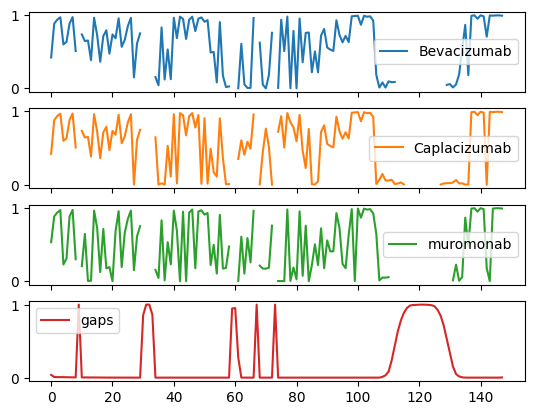

In [84]:
def plot_frequences(counts):
    frequences = compute_frequences('data/alignments/nTopSequences.fasta', counts)
    frequences = pd.DataFrame(frequences)
    frequences.plot(subplots=True)

plot_frequences(counts)